# Imports

In [2]:
# Load NeuroKit and other useful packages
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyxdf
from glob import glob
from scipy.signal import butter, filtfilt

# Load Data

In [3]:
sub_files = glob('../../../Data/*/*.xdf')
sub_files

['../../../Data/sub-P5318014/sub-P5318014_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5942694/sub-P5942694_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-5182010/sub-P5182010_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5287460/sub-P5287460_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5447527/sub-P5447527_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-5958030/sub-P5958030_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5899288/sub-P5899288_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5813427/sub-P5813427_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5070899/sub-P5070899_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5548165/sub-P5548165_ses-S001_task-CUNY_run-001_MOBI.xdf']

In [4]:
sub_number = 4
xdf_path = sub_files[sub_number]
data, header = pyxdf.load_xdf(xdf_path, select_streams=[{'name':'OpenSignals'}, {'type': 'Markers'}])
streams_collected = [stream['info']['name'][0] for stream in data]


'''
HELPERS
'''
def get_event_data(event, df, stim_df):
    return df.loc[(df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & 
                  (df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]

def get_secs_between_triggers(trigger1, trigger2, stim_df):
    return stim_df.loc[stim_df.trigger == trigger1, 'time'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'time'].values[0]

                  
streams_collected

['Stimuli_Markers', 'OpenSignals']

In [5]:
PS = data[streams_collected.index('OpenSignals')]
column_labels = [PS['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(PS['info']['desc'][0]['channels'][0]['channel']))]
ps_df = pd.DataFrame(data=PS['time_series'], columns=column_labels)
ps_df['lsl_time_stamp'] = PS['time_stamps']
ps_df['time'] = (PS['time_stamps'] - PS['time_stamps'][0])/1000
ps_df

,nSeq,RESPIRATION0,ECG1,EDA2,fSpO23,fSpO24,%SpO25,lsl_time_stamp,time
0,652425.0,-0.06958,-0.00593,3.8498,0.61714,0.00000,100.0,168131.660904,0.000000
1,652426.0,-0.06931,-0.00216,3.8490,0.61710,0.00000,100.0,168131.662904,0.000002
2,652427.0,-0.06921,0.00198,3.8498,0.61716,0.00000,100.0,168131.664905,0.000004
3,652428.0,-0.06940,0.00521,3.8475,0.61712,0.00000,100.0,168131.666905,0.000006
4,652429.0,-0.06921,0.00916,3.8498,0.61714,0.00000,100.0,168131.668905,0.000008
...,...,...,...,...,...,...,...,...,...
1251963,1904388.0,0.35266,0.10045,5.9914,0.58907,0.00000,100.0,170635.898877,2.504238
1251964,1904389.0,0.35211,0.09919,5.9914,0.59004,0.00000,100.0,170635.900877,2.504240
1251965,1904390.0,0.35156,0.09937,5.9898,0.59033,1.19927,100.0,170635.902878,2.504242
1251966,1904391.0,0.35046,0.09955,5.9914,0.59057,0.00000,100.0,170635.904878,2.504244


In [34]:
srate = PS['info']['effective_srate']

rsp_df = ps_df[['RESPIRATION0', 'lsl_time_stamp']].rename(columns={'RESPIRATION0': 'respiration'})
rsp_df['time'] = rsp_df['lsl_time_stamp'] - rsp_df['lsl_time_stamp'][0]
rsp = rsp_df.respiration
rsp

0         -0.06958
1         -0.06931
2         -0.06921
3         -0.06940
4         -0.06921
            ...   
1251963    0.35266
1251964    0.35211
1251965    0.35156
1251966    0.35046
1251967    0.34955
Name: respiration, Length: 1251968, dtype: float32

# Visualize Respiration

Text(0, 0.5, 'Voltage (V)')

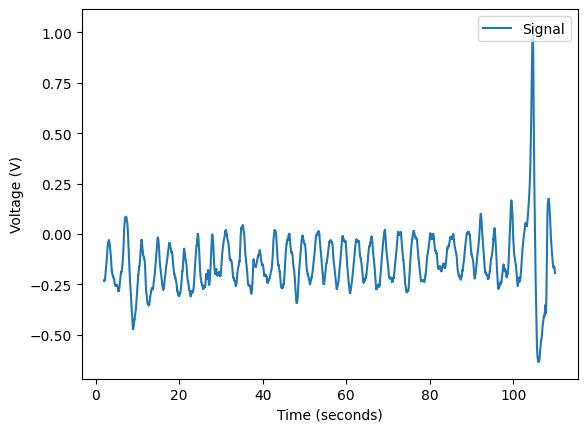

In [7]:
# plot raw
# 100 seconds * 500 samps/second = 50000 samps
nk.signal_plot(rsp[1000:55000], sampling_rate=srate)
plt.ylabel('Voltage (V)')

In [8]:
# Clean signal
cleaned = nk.rsp_clean(rsp, sampling_rate=srate, method = 'khodadad')

# Extract peaks
peaks_df, peaks_dict = nk.rsp_peaks(cleaned) # peaks_df: 1 where peaks and troughs are. dict: samples where peaks and troughs are
fixed_peaks = nk.rsp_fixpeaks(peaks_dict)
formatted = nk.signal_formatpeaks(fixed_peaks, desired_length=len(cleaned),peak_indices=fixed_peaks["RSP_Peaks"]) # what is this for

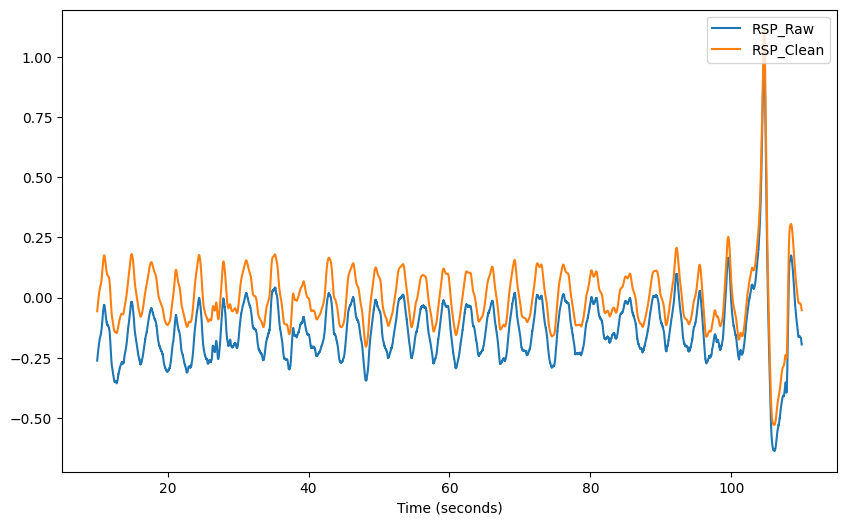

In [9]:
# compare raw and clean signal
plt.rcParams['figure.figsize'] = [10, 6]
nk.signal_plot(pd.DataFrame({"RSP_Raw": rsp[5000:55000], "RSP_Clean": cleaned[5000:55000]}), sampling_rate=srate) # subplots = True

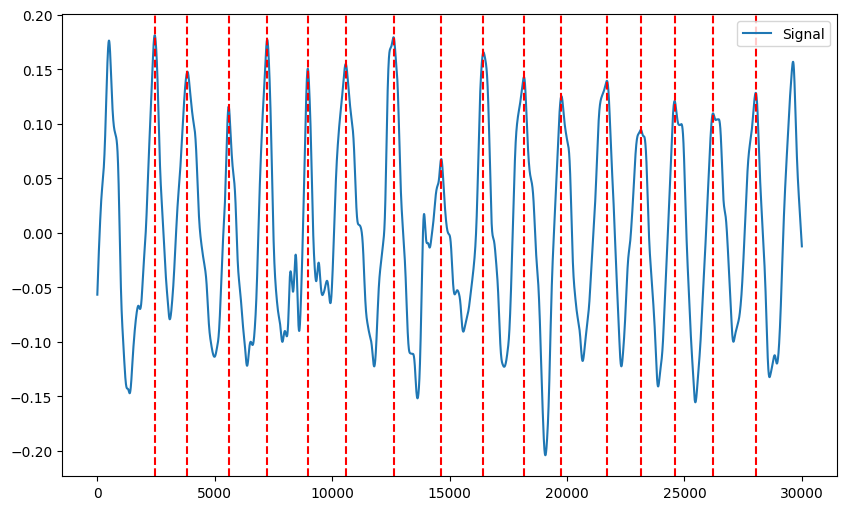

In [10]:
# mark peaks
short_peaks_df, short_peaks_dict = nk.rsp_peaks(cleaned[5000:35000]) # peaks_df: 1 where peaks and troughs are. dict: samples where peaks and troughs are
short_peaks_plot = nk.events_plot(short_peaks_dict['RSP_Peaks'], cleaned[5000:35000])

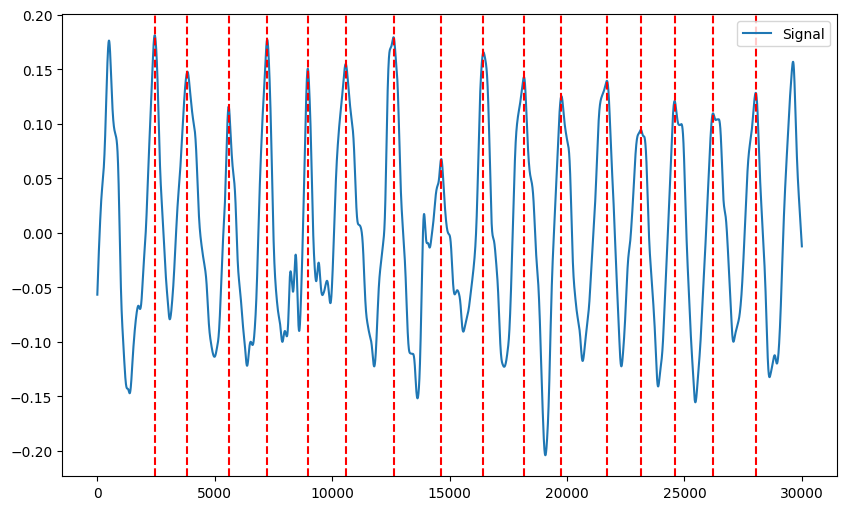

In [11]:
short_fixed_peaks = nk.rsp_fixpeaks(short_peaks_dict) # dict: samples where peaks are  ?
short_fixed_peaks_plot = nk.events_plot(short_fixed_peaks['RSP_Peaks'], cleaned[5000:35000])

# Breath Amplitude

In [12]:
# get the values of the troughs
troughs_values = cleaned[peaks_df['RSP_Troughs'].to_numpy() == 1]
troughs_values[:10]

array([-0.112366  , -0.10627626, -0.2721384 , -0.14710607, -0.07928382,
       -0.1136726 , -0.12188352, -0.09996613, -0.06449137, -0.12247676])

In [13]:
peaks_values = cleaned[peaks_df['RSP_Peaks'].to_numpy() == 1]
peaks_values[:10]

array([0.12166101, 0.27474012, 0.17627802, 0.18114906, 0.14769055,
       0.11574405, 0.17714563, 0.15053676, 0.15483451, 0.17935193])

In [14]:
raw_peaks_values = rsp.to_numpy()[peaks_df['RSP_Peaks'].to_numpy() == 1]

raw_troughs_values = rsp.to_numpy()[peaks_df['RSP_Troughs'].to_numpy() == 1]


In [15]:
raw_breath_amplitude = raw_peaks_values-raw_troughs_values
print(f'mean = {np.nanmean(raw_breath_amplitude):.4}')
print(f'std = {np.nanstd(raw_breath_amplitude):.4}')
print(f'range = {np.nanmin(raw_breath_amplitude):.4} - {np.nanmax(raw_breath_amplitude):.4}')

mean = 0.2956
std = 0.3108
range = 0.02545 - 2.647


In [16]:
len(rsp)

1251968

In [17]:
breath_amplitude = peaks_values-troughs_values
print(f'mean = {np.mean(breath_amplitude):.4}')
print(f'std = {np.std(breath_amplitude):.4}')
print(f'range = {np.min(breath_amplitude):.4} - {np.max(breath_amplitude):.4}')

mean = 0.292
std = 0.3126
range = 0.01963 - 2.646


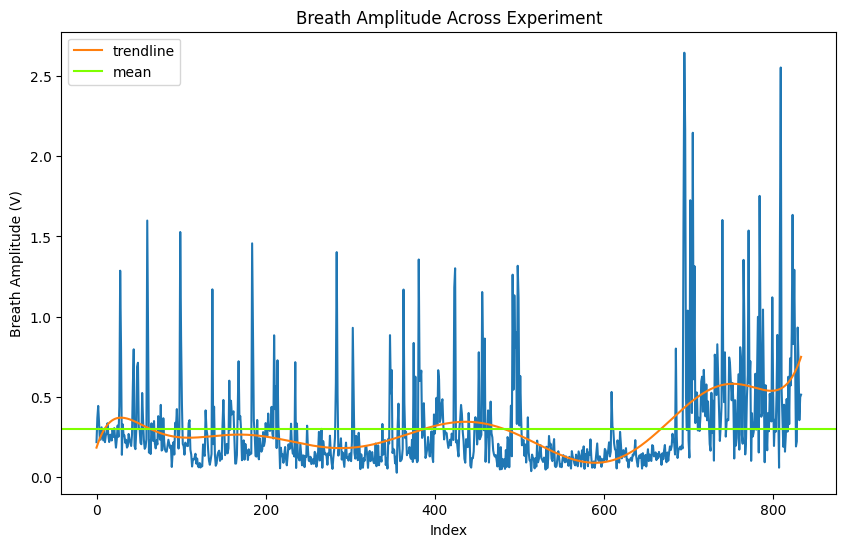

In [18]:
x = np.arange(len(raw_breath_amplitude))
y = raw_breath_amplitude
z = np.polyfit(x, y, 10)
p = np.poly1d(z)
plt.plot(x, y)
plt.plot(x, p(x), label = 'trendline')
plt.axhline(np.mean(raw_breath_amplitude), color = 'chartreuse', label = 'mean')
plt.legend()
plt.ylabel('Breath Amplitude (V)')
plt.xlabel('Index')
plt.title('Breath Amplitude Across Experiment')
plt.show()

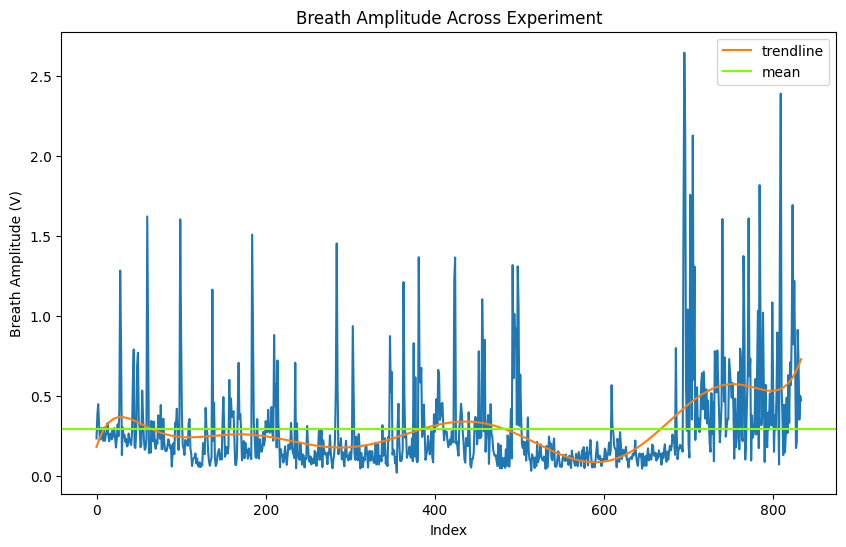

In [19]:
x = np.arange(len(breath_amplitude))
y = breath_amplitude
z = np.polyfit(x, y, 10)
p = np.poly1d(z)
plt.plot(x, y)
plt.plot(x, p(x), label = 'trendline')
plt.axhline(np.mean(breath_amplitude), color = 'chartreuse', label = 'mean')
plt.legend()
plt.ylabel('Breath Amplitude (V)')
plt.xlabel('Index')
plt.title('Breath Amplitude Across Experiment')
plt.show()

In [20]:
import seaborn as sns

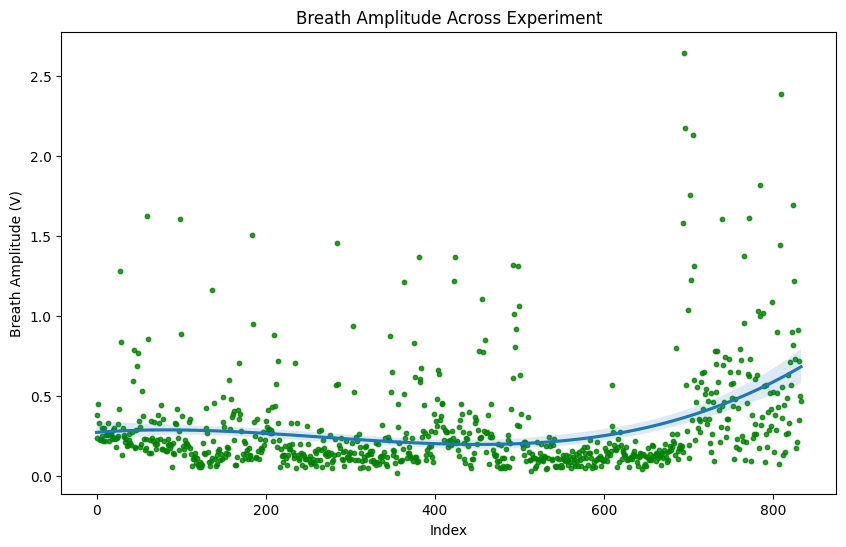

In [21]:
sns.regplot(x = x, y = y, order = 3, ci = 95, scatter_kws={'s': 10, 'color': 'g'})
plt.ylabel('Breath Amplitude (V)')
plt.xlabel('Index')
plt.title('Breath Amplitude Across Experiment')
plt.show()

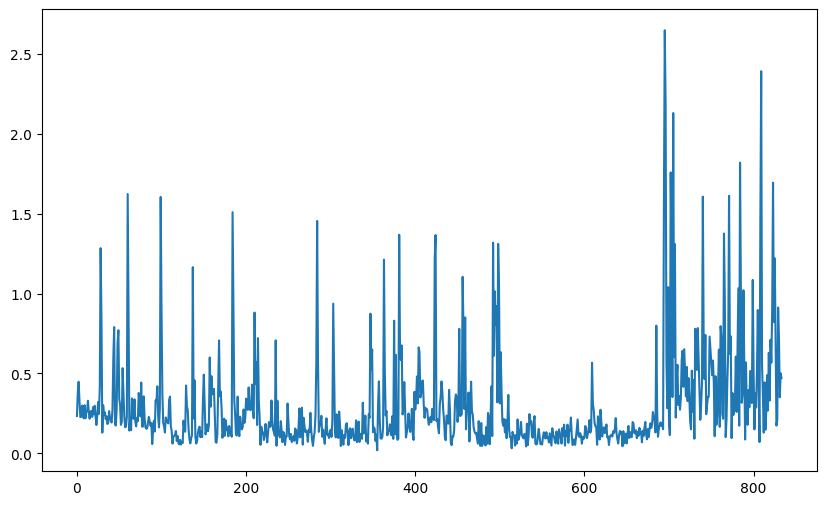

In [22]:

plt.plot(breath_amplitude)

# Respiration Rate

In [23]:
srate

499.9377110588043

Text(0.5, 1.0, 'Comparing Rsp Rate Methods-- 80 second sample')

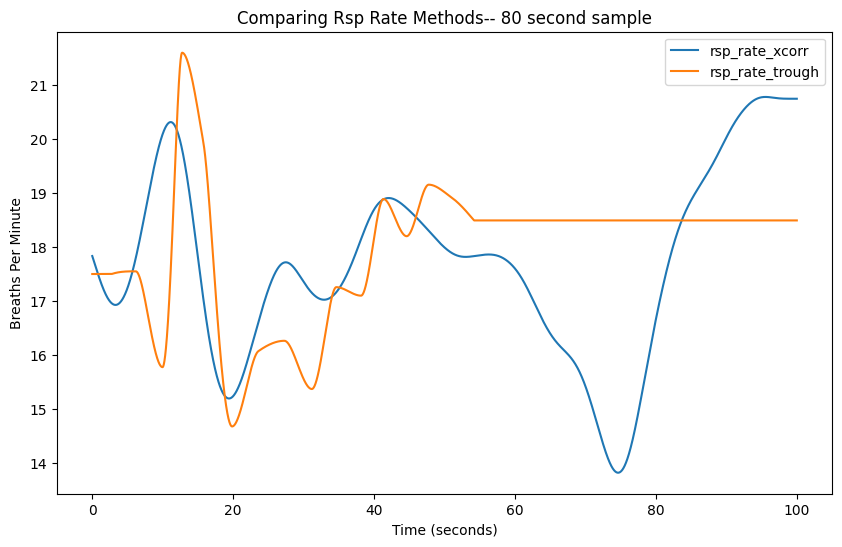

In [24]:
# Extract rate
rsp_rates_short = pd.DataFrame({
    'rsp_rate_xcorr': nk.rsp_rate(cleaned[5000:55000], short_peaks_dict, sampling_rate=srate, method = 'xcorr'),
    'rsp_rate_trough': nk.rsp_rate(cleaned[5000:55000], short_peaks_dict, sampling_rate=srate, method = 'trough')    
})
# rsp_rate_xcorr = nk.rsp_rate(cleaned[5000:55000], short_peaks_dict, sampling_rate=srate, method = 'xcorr')
# rsp_rate_trough = nk.rsp_rate(cleaned[5000:55000], short_peaks_dict, sampling_rate=srate, method = 'trough')
# Visualize
nk.signal_plot(rsp_rates_short, sampling_rate=srate) 
plt.ylabel('Breaths Per Minute')
plt.title('Comparing Rsp Rate Methods-- 80 second sample')

Text(0.5, 1.0, 'Comparing Rsp Rate Methods-- Whole Experiment')

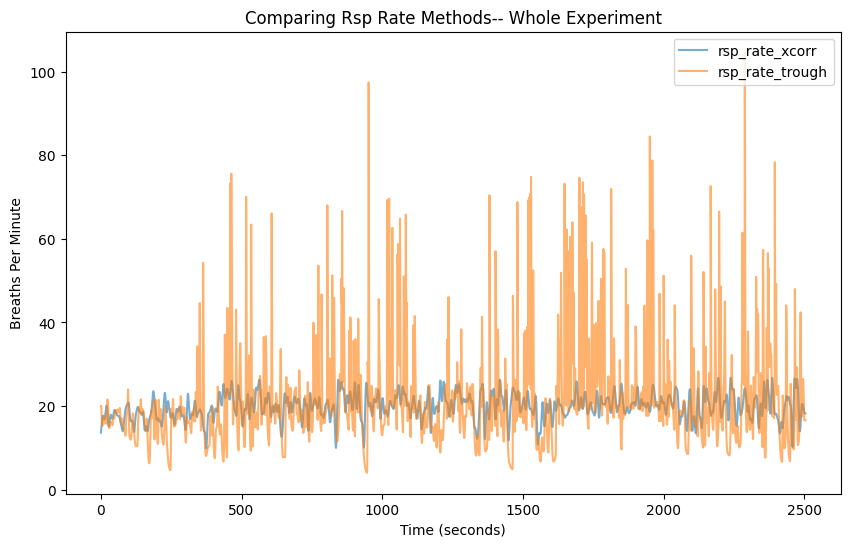

In [25]:
# Extract rate (whole)
rsp_rates_whole = pd.DataFrame({
    'rsp_rate_xcorr': nk.rsp_rate(cleaned, peaks_dict, sampling_rate=srate, method = 'xcorr'),
    'rsp_rate_trough': nk.rsp_rate(cleaned, peaks_dict, sampling_rate=srate, method = 'trough')    
})
# Visualize
nk.signal_plot(rsp_rates_whole, sampling_rate=srate, alpha = 0.6)
plt.ylabel('Breaths Per Minute')
plt.title('Comparing Rsp Rate Methods-- Whole Experiment')
# ax.get_lines()[signals.columns.get_loc("RSP_Raw")].set_alpha(0.5) # adjust alpha for one column

In [26]:
print('sample rsp rate mean: trough', np.mean(rsp_rates_short['rsp_rate_trough']))
print('sample rsp rate mean: xcorr', np.mean(rsp_rates_short['rsp_rate_xcorr']))

print('sample rsp rate std: trough', np.std(rsp_rates_short['rsp_rate_trough']))
print('sample rsp rate std: xcorr', np.std(rsp_rates_short['rsp_rate_xcorr']))

sample rsp rate mean: trough 17.95782417778123
sample rsp rate mean: xcorr 17.70719954700604
sample rsp rate std: trough 1.261150624435874
sample rsp rate std: xcorr 1.7032631217132812


In [27]:
print('whole experiment rsp rate mean: trough', np.mean(rsp_rates_whole['rsp_rate_trough']))
print('whole experiment rsp rate mean: xcorr', np.mean(rsp_rates_whole['rsp_rate_xcorr']))

print('whole experiment rsp rate std: trough', np.std(rsp_rates_whole['rsp_rate_trough']))
print('whole experiment rsp rate std: xcorr', np.std(rsp_rates_whole['rsp_rate_xcorr']))

whole experiment rsp rate mean: trough 20.888158631618165
whole experiment rsp rate mean: xcorr 19.847510617588135
whole experiment rsp rate std: trough 10.278426456925288
whole experiment rsp rate std: xcorr 2.919622590374971


In [28]:
print(f'whole experiment rsp rate range: trough {np.min(rsp_rates_whole['rsp_rate_trough']):.4} - {np.max(rsp_rates_whole['rsp_rate_trough']):.4}')
print(f'whole experiment rsp rate range: xcorr {np.min(rsp_rates_whole['rsp_rate_xcorr']):.4} - {np.max(rsp_rates_whole['rsp_rate_xcorr']):.4}')

whole experiment rsp rate range: trough 4.051 - 104.5
whole experiment rsp rate range: xcorr 9.863 - 26.77


In [29]:
print(f'sample rsp rate range: trough {np.min(rsp_rates_short['rsp_rate_trough']):.4} - {np.max(rsp_rates_short['rsp_rate_trough']):.4}')
print(f'sample rsp rate range: xcorr {np.min(rsp_rates_short['rsp_rate_xcorr']):.4} - {np.max(rsp_rates_short['rsp_rate_xcorr']):.4}')

sample rsp rate range: trough 14.68 - 21.6
sample rsp rate range: xcorr 13.83 - 20.78


# Plot Experiment Sections of Raw

In [30]:
events = {
    200: 'Onset_Experiment',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_Experiment',
}

story_onsets = [20, 30, 40, 50, 60, 70]

In [31]:
# get data for experiment section 
# resting state, story listening, maybe stories separately? like 5 graphs in one 
stim_dat = data[streams_collected.index('Stimuli_Markers')]
stim_df = pd.DataFrame(stim_dat['time_series'])
stim_df.rename(columns={0: 'trigger'}, inplace=True)
story_onsets = [20, 30, 40, 50, 60, 70]
stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')
stim_df.loc[stim_df.trigger.astype(str).str.len() > 5, 'event'] = 'psychopy_time_stamp'
stim_df['lsl_time_stamp'] = stim_dat['time_stamps']
stim_df['diff'] = stim_df['lsl_time_stamp'].diff()



In [36]:
# get data for experiment section 
# resting state, story listening, maybe stories separately? like 5 graphs in one 
def get_event_data(event, df, stim_df):
    return df.loc[(df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & 
                  (df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]

rsp_resting_state = get_event_data('RestingState', rsp_df, stim_df)
rsp_story_listening = get_event_data('StoryListening', rsp_df, stim_df)

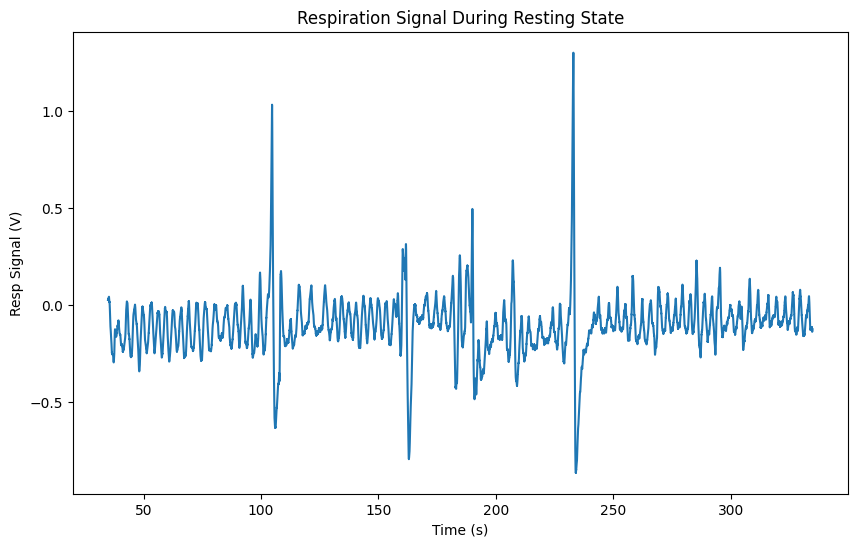

In [37]:
plt.plot(rsp_resting_state.time, rsp_resting_state.respiration)
plt.xlabel("Time (s)")
plt.ylabel("Resp Signal (V)")
plt.title("Respiration Signal During Resting State")
plt.show()

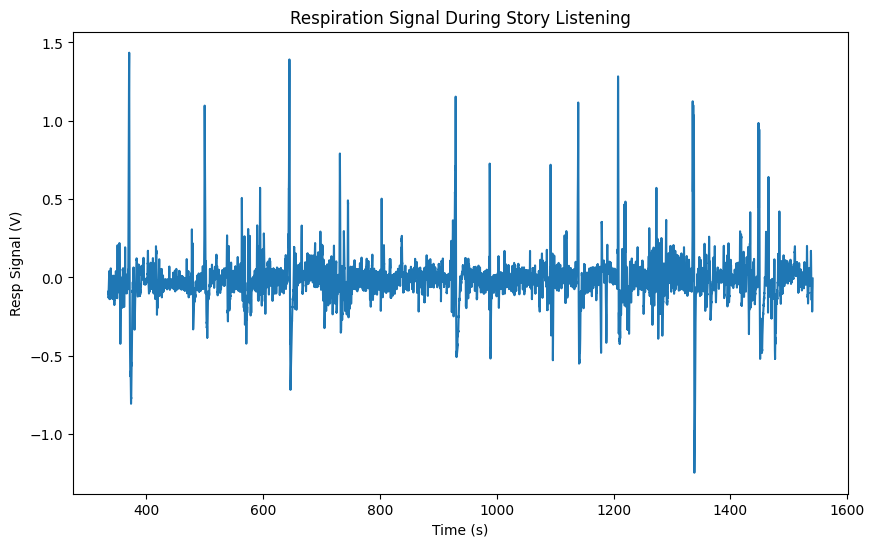

In [38]:
plt.plot(rsp_story_listening.time, rsp_story_listening.respiration)
plt.xlabel("Time (s)")
plt.ylabel("Resp Signal (V)")
plt.title("Respiration Signal During Story Listening")
plt.show()

In [39]:
# get list of stories in order 
stories_df = pd.DataFrame(columns = ['name', 'lsl_time_stamp'])
for i in story_onsets:
    stories_df.loc[i, 'name'] = events[i].split('_')[1]
    stories_df.loc[i, 'lsl_time_stamp'] = stim_df.loc[stim_df.event == events[i], 'lsl_time_stamp'].values[0]

stories_df.sort_values(by = 'lsl_time_stamp', inplace = True)
stories = (stories_df.name).tolist()
stories
# stories_dict['lsl_time_stamp'].sort !!!
# stories = stories_dict['event_name']


['BirthdayParty',
 'ZoomClass',
 'Tornado',
 'FrogDissection',
 'DanceContest',
 'CampFriend']

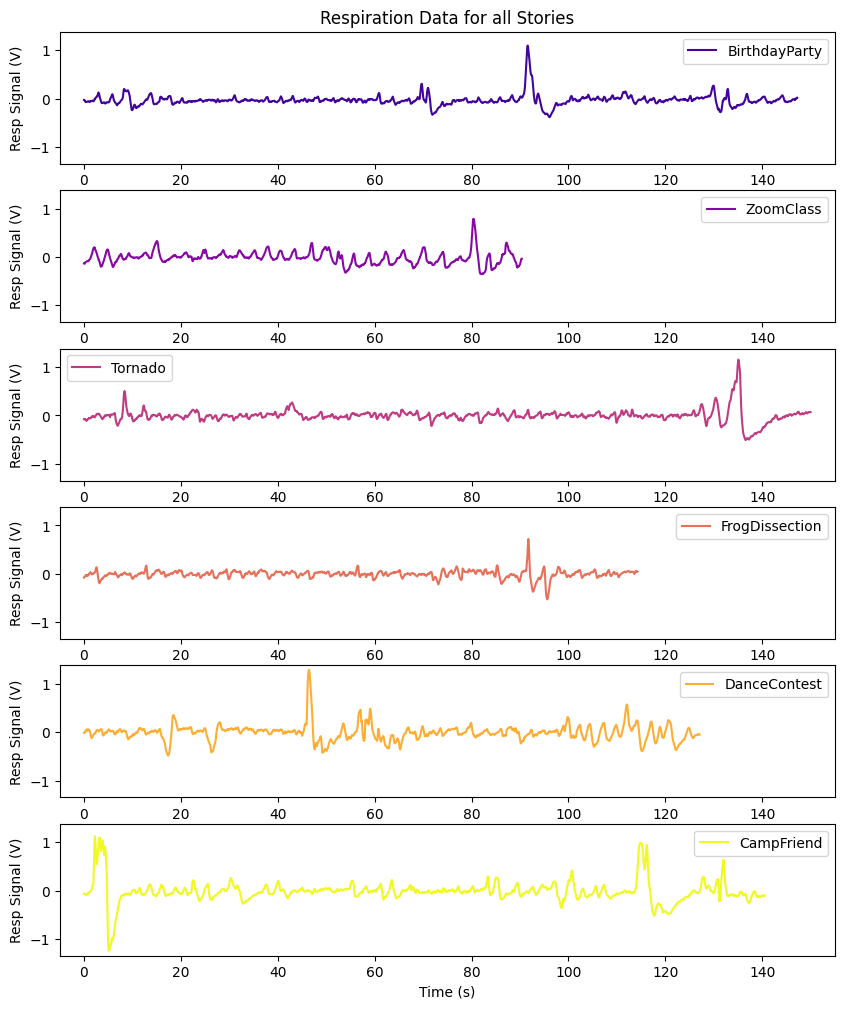

In [40]:
colors = plt.cm.plasma(np.linspace(.1, 1, len(stories)))
fig, ax = plt.subplots(figsize=(10,12), nrows=len(stories), ncols=1)
max_x = 0
max_y = 0
min_y = 0

for i, story in enumerate(stories): 
    # make df for current story
    rsp_story = get_event_data(story, rsp_df, stim_df).reset_index()
    rsp_story['time'] = rsp_story.lsl_time_stamp - rsp_story.lsl_time_stamp[0]

    # get max to set x + y lim later
    current_maxx = rsp_story['time'].max()
    current_maxy = rsp_story['respiration'].max()
    current_miny = rsp_story['respiration'].min()
    if current_maxx > max_x:
        max_x = current_maxx
    if current_maxy > max_y:
        max_y = current_maxy
    if current_miny < min_y:
        min_y = current_miny

    # plot
    ax[i].plot(rsp_story.time, rsp_story.respiration, label = story, color = colors[i])
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Resp Signal (V)")
    ax[i].legend()

# set axis to be the same
for axis in ax:
    axis.set_xlim([-5, max_x + 5])
    axis.set_ylim([min_y-0.1, max_y+0.1])


ax[0].set_title("Respiration Data for all Stories")
plt.show()


# Peak to Peak interval

In [42]:
rsp_df['cleaned'] = cleaned
rsp_df

# get all rows of rsp_df where peaks_df = 1

ptp_df = rsp_df[peaks_df['RSP_Peaks'].to_numpy() == 1]
ptp_df.reset_index(drop = True, inplace = True)
ptp_df['time'] = ptp_df.lsl_time_stamp - ptp_df.lsl_time_stamp[0]
ptp = ptp_df.lsl_time_stamp.diff()
ptp 


/var/folders/8t/3zxw9ymj0dz7gvv5vyvt45j4wh1rnl/T/ipykernel_2400/3281864597.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ptp_df['time'] = ptp_df.lsl_time_stamp - ptp_df.lsl_time_stamp[0]


0           NaN
1      4.040503
2      3.782471
3      3.894485
4      2.790348
         ...   
829    2.706337
830    3.394423
831    2.708337
832    1.288160
833    4.490559
Name: lsl_time_stamp, Length: 834, dtype: float64

In [43]:
ptp

0           NaN
1      4.040503
2      3.782471
3      3.894485
4      2.790348
         ...   
829    2.706337
830    3.394423
831    2.708337
832    1.288160
833    4.490559
Name: lsl_time_stamp, Length: 834, dtype: float64

In [44]:
dict(color = 'r')

{'color': 'r'}

In [45]:
print(f'mean: {np.nanmean(ptp):.4} \n\
std: {np.nanstd(ptp):.4} \n\
range: {np.nanmin(ptp):.4} - {np.nanmax(ptp):.4}')

mean: 2.999 
std: 1.476 
range: 0.6741 - 12.82


Text(0.5, 0, 'Time ')

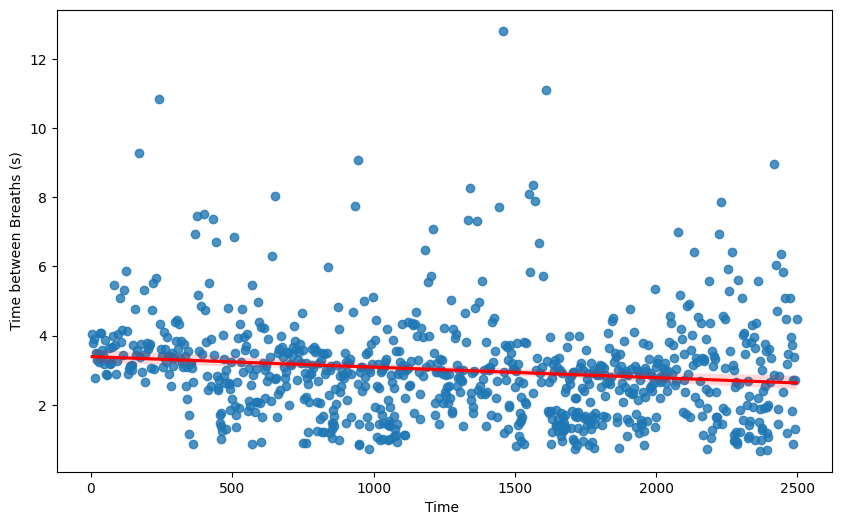

In [46]:
sns.regplot(x = ptp_df.time, y = ptp.to_numpy(), line_kws = {'color': 'r'}, ci = 95)
plt.ylabel('Time between Breaths (s)')
plt.xlabel('Time ')

# Baseline Drift

In [47]:
# define time
rsp_df['time'] = rsp_df['lsl_time_stamp'] - rsp_df['lsl_time_stamp'][0]


### Polynomial (delete)

In [48]:
# fit polynomial line 
time = rsp_df['time']
coeffs = np.polyfit(time, rsp, deg = 2)
polynomial = np.polyval(coeffs, time)
polynomial

array([-0.11129686, -0.11129658, -0.11129631, ..., -0.04055887,
       -0.04055903, -0.0405592 ])

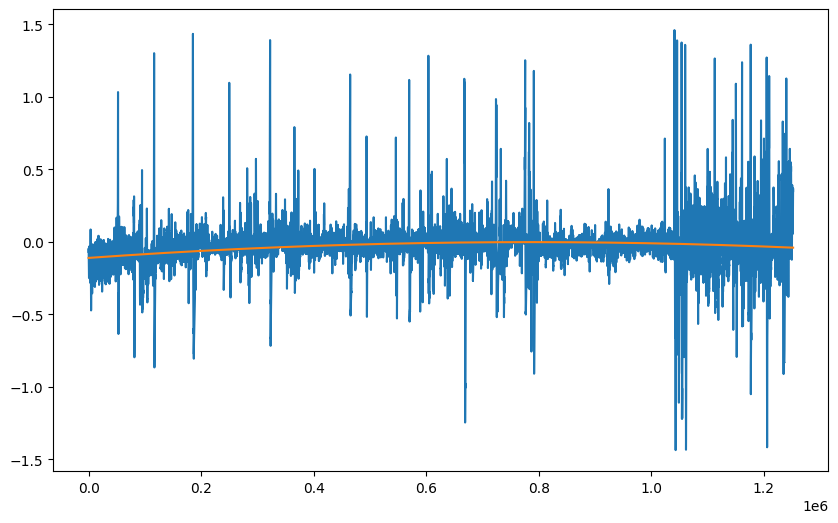

In [49]:
# plot polynomial line w raw data
fig, ax = plt.subplots()
ax.plot(rsp)
ax.plot(polynomial)


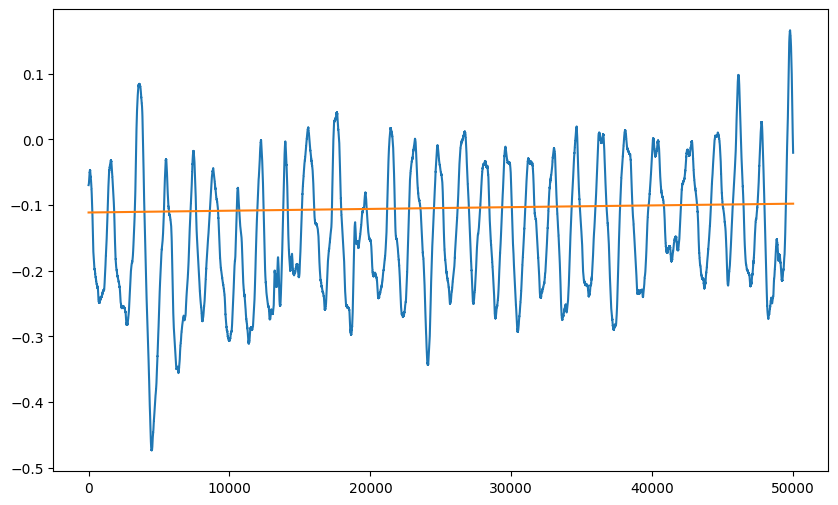

In [50]:
fig, ax = plt.subplots()
ax.plot(rsp[:50000])
ax.plot(polynomial[:50000])

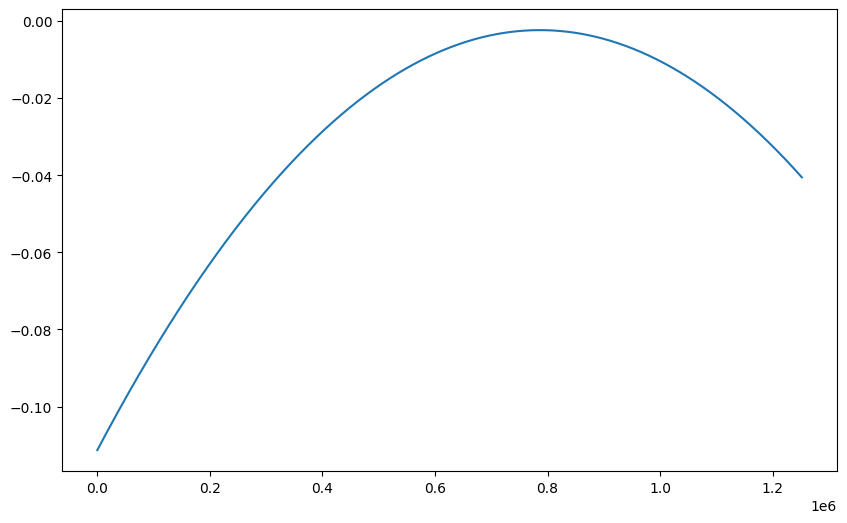

In [51]:
plt.plot(polynomial)

### Rolling Max-Min 

In [52]:
# rolling max-min
# total range
signal_range = np.max(rsp) - np.min(rsp)

# rolling range 
rolling_min = rsp.rolling(window=5000).min()
rolling_max = rsp.rolling(window=5000).max()

# get shift in each window (rolling)
rollmax_min = (rolling_max - rolling_min).dropna()

excessive_drift = rollmax_min > .1*signal_range
# percent_excessive_drift = excessive_drift.sum()/len(drift) * 100

# print(f'{percent_excessive_drift:.4}%')

rollmax_min

4999       0.55829
5000       0.55829
5001       0.55829
5002       0.55829
5003       0.55829
            ...   
1251963    0.67108
1251964    0.67108
1251965    0.67108
1251966    0.67108
1251967    0.67108
Name: respiration, Length: 1246969, dtype: float64

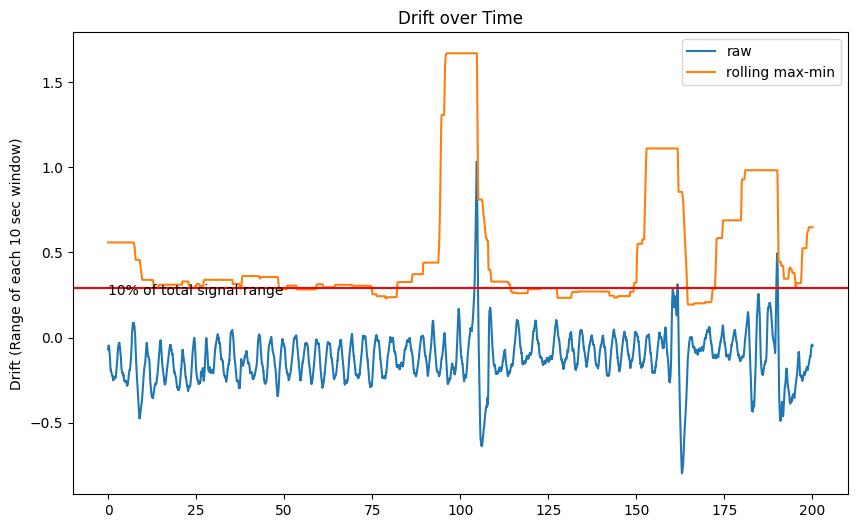

In [53]:
# drift = max-min for each 10 sec window
plt.plot(rsp_df.time[:100000], rsp[:100000], label = "raw")
plt.plot(rsp_df.time[:100000], rollmax_min[:100000], label = "rolling max-min")
plt.axhline(signal_range *.1, color = 'red')
plt.text(x = 0, y = .25, s = "10% of total signal range")
plt.title("Drift over Time")
plt.ylabel("Drift (Range of each 10 sec window)")
plt.legend()

### Average slope of rolling mean

In [54]:
# different ways to get drift

# rolling mean-- done 
# low pass filtering (smooth trend extraction )
# savitzky golay (polynomial based smoothing)

In [55]:
# rolling mean slope- overall drift trend
    # rolling mean
rolling_mean = pd.Series(rsp).rolling(window=5000, center=True).mean().dropna()
slope = np.gradient(rolling_mean)
slope

# std: variability of slope (fluctuations), mean: magnitude of total slope change (this is what we want)
np.std(slope), np.abs(slope).mean()
# rolling range- short term variability um no 

np.abs(slope).mean()/signal_range

# low pass filtering standard dev- long term drift estimation 


1.0885446253582259e-05

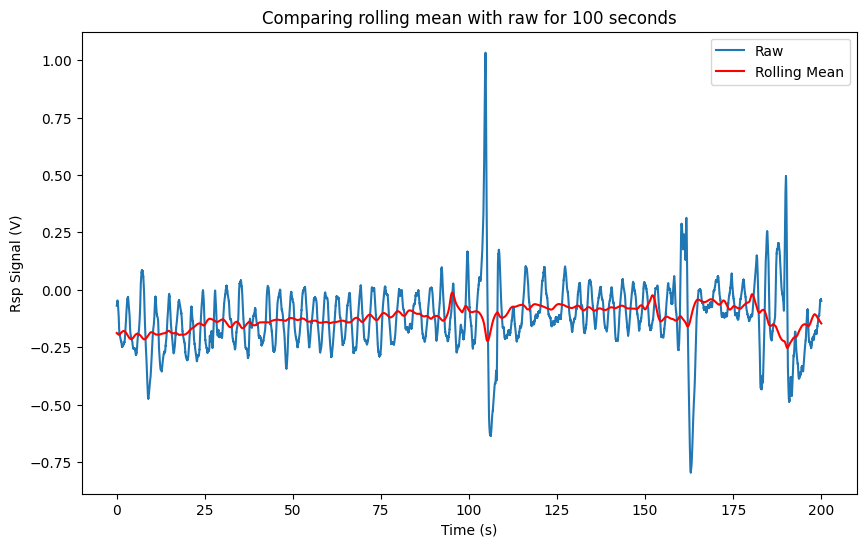

In [56]:
plt.plot(rsp_df.time[:100000], rsp[:100000], label = "Raw")
plt.plot(rsp_df.time[:100000], rolling_mean.reset_index(drop = True)[:100000], color = 'r', label = "Rolling Mean")
plt.title('Comparing rolling mean with raw for 100 seconds')
plt.xlabel('Time (s)')
plt.ylabel('Rsp Signal (V)')
plt.legend()
plt.show()

### Low pass filter

In [57]:
# low pass filtering standard dev- long term drift estimation 
def lowpass_filter(data, cutoff=0.05, fs=500, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)
lowpass = lowpass_filter(rsp)
np.std(lowpass)

0.05968073492018064

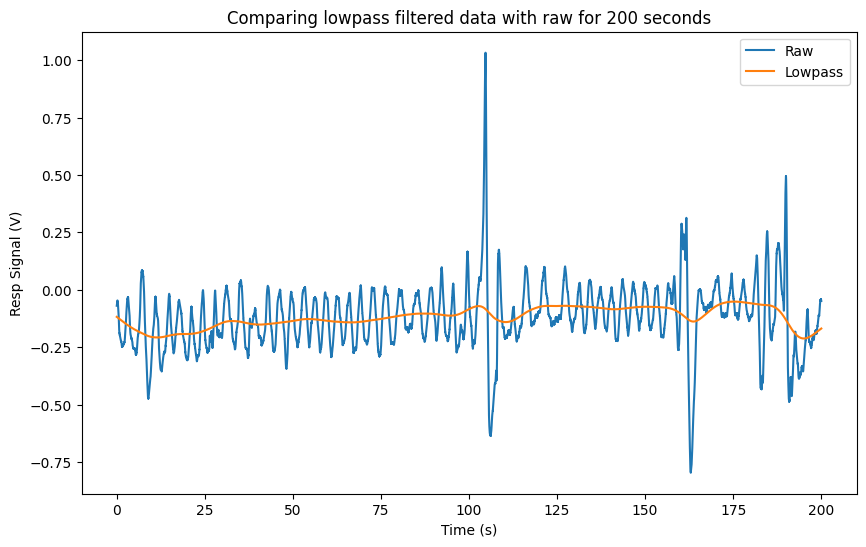

In [58]:
plt.plot(rsp_df.time[:100000], rsp[:100000], label = "Raw")
plt.plot(rsp_df.time[:100000], lowpass[:100000], label = "Lowpass")
plt.title("Comparing lowpass filtered data with raw for 200 seconds")
plt.xlabel("Time (s)")
plt.ylabel("Resp Signal (V)")
plt.legend()

### Plot

In [59]:
subject = sub_files[sub_number].split('/')[4].split('-')[1]
subject

'P5447527'

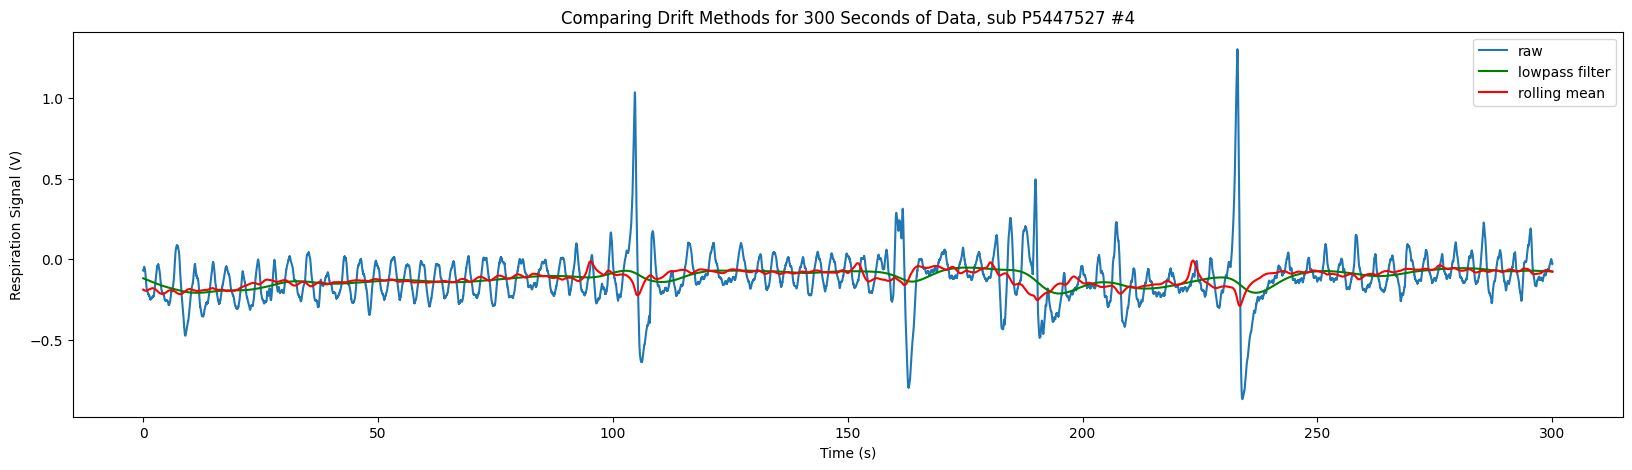

In [60]:
# plotting lowpass + rolling mean-- 100 second subset 
plt.figure(figsize = (20, 5))
plt.plot(rsp_df.time[:150000], rsp[:150000], label = "raw")
plt.plot(rsp_df.time[:150000], lowpass[:150000], label = "lowpass filter", color = 'g')
# plt.axhline(signal_range *.1, color = 'g', label = "10% of signal range")
plt.plot(rsp_df.time[:150000], rolling_mean.reset_index(drop = True)[:150000], color = 'r', label = "rolling mean")
# plt.plot(rsp_df.time[:50000], rollmax_min[:50000], label = "Rolling Max-Min")
plt.title(f'Comparing Drift Methods for 300 Seconds of Data, sub {subject} #{sub_number}')
plt.xlabel('Time (s)')
plt.ylabel('Respiration Signal (V)')
plt.legend()
plt.savefig(f'/Users/camilla.strauss/Downloads/drift/300_{subject}.png', bbox_inches='tight')

plt.show()

# average slope of the rolling mean or std of the lowpass filter



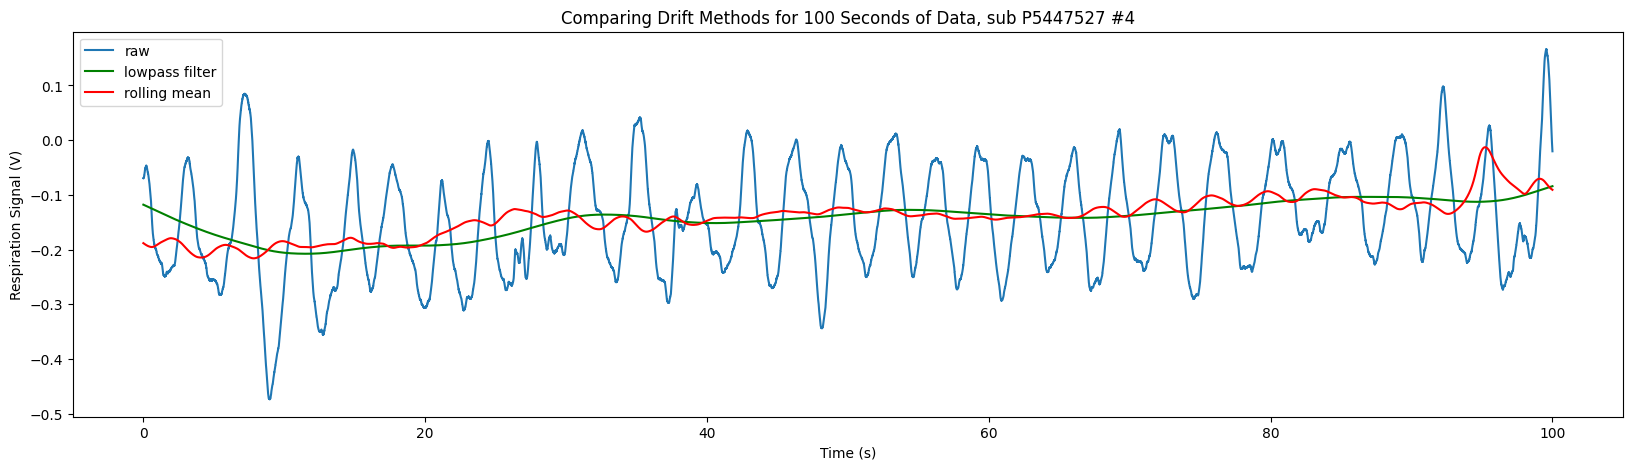

In [61]:
# plotting lowpass + rolling mean-- 100 second subset 
plt.figure(figsize = (20, 5))
plt.plot(rsp_df.time[:50000], rsp[:50000], label = "raw")
plt.plot(rsp_df.time[:50000], lowpass[:50000], label = "lowpass filter", color = 'g')
# plt.axhline(signal_range *.1, color = 'g', label = "10% of signal range")
plt.plot(rsp_df.time[:50000], rolling_mean.reset_index(drop = True)[:50000], color = 'r', label = "rolling mean")
# plt.plot(rsp_df.time[:50000], rollmax_min[:50000], label = "Rolling Max-Min")
plt.title(f'Comparing Drift Methods for 100 Seconds of Data, sub {subject} #{sub_number}')
plt.xlabel('Time (s)')
plt.ylabel('Respiration Signal (V)')
plt.legend()
plt.savefig(f'/Users/camilla.strauss/Downloads/drift/100_{subject}.png', bbox_inches='tight')
plt.show()

# average slope of the rolling mean or std of the lowpass filter



In [62]:
# print std of lowpass and av slope
print(f'std of lowpass: {np.std(lowpass):.4f} \n\
average slope of rolling mean: {np.abs(slope).mean():.8f}')

std of lowpass: 0.0597 
average slope of rolling mean: 0.00003153


In [63]:
# plt.plot(slope, color = 'b', label = "Slope of Rolling Mean")
# plt.plot(rolling_mean.reset_index(drop = True), color = 'r', label = "Rolling Mean")
# plt.plot(rollmax_min, label = "Rolling Max-Min")
# plt.axhline(signal_range *.1, color = 'g', label = "10% of signal range")
# plt.title("Rolling Mean and its Slope")
# plt.legend()

### Savgol (barely does anything)

In [64]:
detrended = rsp-lowpass
print('mean:', (np.abs(detrended)).mean(), \
    'std: ', np.std(detrended))

mean: 0.09572614848624089 std:  0.17405483569329613


In [66]:
from scipy.signal import savgol_filter
savgol = savgol_filter(rsp, window_length=101, polyorder=2)
detrended = rsp-savgol
print('mean:', (np.abs(detrended)).mean(), \
    'std: ', np.std(detrended))

mean: 0.00049202796 std:  0.0008481015102006495


In [67]:
# from scipy.signal import savgol_filter

# # Estimate baseline drift using a smoothing method
# savgol = savgol_filter(rsp, window_length=101, polyorder=2)

# # Compute signal range
# signal_range = np.max(rsp) - np.min(rsp)

# # Define rolling window size (e.g., 50 samples)
# window_size = 50

# # Compute rolling baseline shift
# savgol_series = pd.Series(savgol)
# rolling_min = savgol_series.rolling(window=window_size).min()
# rolling_max = savgol_series.rolling(window=window_size).max()

# # Measure shift within each window
# savgol_change = rolling_max - rolling_min

# # Flag excessive drift
# excessive_savgol = savgol_change > 0.1 * signal_range

# print(excessive_savgol.sum(), "windows exceed the drift threshold")

# # Optional: Plot drift changes over time
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 4))
# plt.plot(savgol[:5000], label="Savgol Filter", color="blue")
# # plt.plot(savgol_change[:5000], color = 'g', label = "Savgol Max-Min")
# # plt.plot(rollmax_min[:5000], color = 'orange', label = "Reg Max-Min")
# plt.plot(rsp[:5000], color = 'chartreuse', label = 'Raw')
# plt.axhline(signal_range*.1)
# # plt.plot()
# # plt.plot(excessive_savgol * np.max(savgol), 'r', label="Excessive Drift Regions")  # Mark excessive drift
# plt.legend()
# plt.show()


# Autocorrelation

In [68]:
rsp_df['time'] = rsp_df.lsl_time_stamp - rsp_df.lsl_time_stamp[0]
peak_times = rsp_df['time'][peaks_df['RSP_Peaks'] == 1]
breath_intervals = np.diff(peak_times)  # Time differences between peaks
median_breath_period = np.median(breath_intervals)  # Typical breathing period

In [69]:
# lag = number of samples between each breath
autocorr = rsp.autocorr(lag=int(median_breath_period * srate))

print(f"Autocorrelation at typical breath cycle: {autocorr:.4f}")

Autocorrelation at typical breath cycle: -0.0600


In [70]:
lag = int(median_breath_period * srate)
lag

1467

In [97]:
len(rsp_df)

TypeError: 'int' object is not callable

In [94]:
len = len(rsp)

TypeError: 'int' object is not callable

In [95]:
rsp.iloc[-(lag+1):]

1250500    0.21533
1250501    0.21442
1250502    0.21313
1250503    0.21204
1250504    0.21112
            ...   
1251963    0.35266
1251964    0.35211
1251965    0.35156
1251966    0.35046
1251967    0.34955
Name: respiration, Length: 1468, dtype: float32

Text(0.5, 1.0, "np.correlate(rsp, rsp, mode='full')")

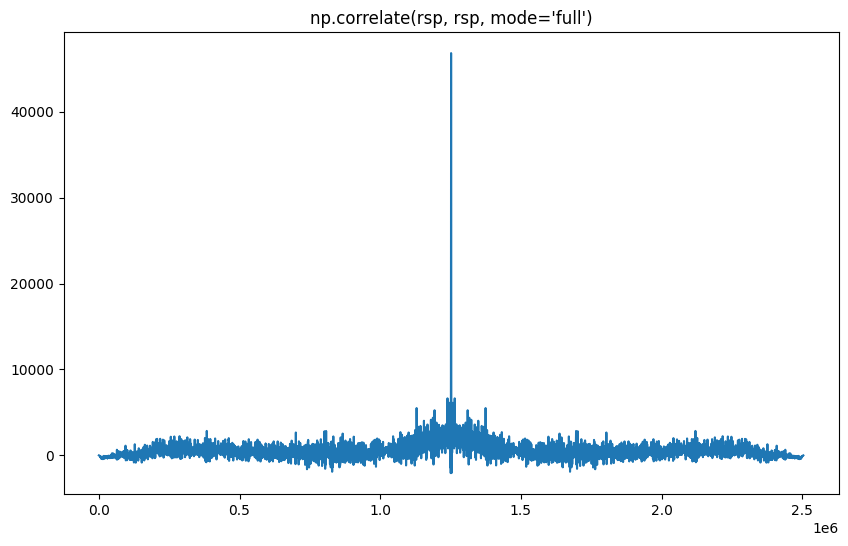

In [120]:
plt.plot(convolution2)
plt.title("np.correlate(rsp, rsp, mode='full')")

In [110]:
convolution2 = np.correlate(rsp, rsp, mode='full')

In [ ]:
convolution = np.correlate(rsp, shift, mode='full')

Text(0.5, 1.0, "np.correlate(rsp, rsp_shifted, mode='full')")

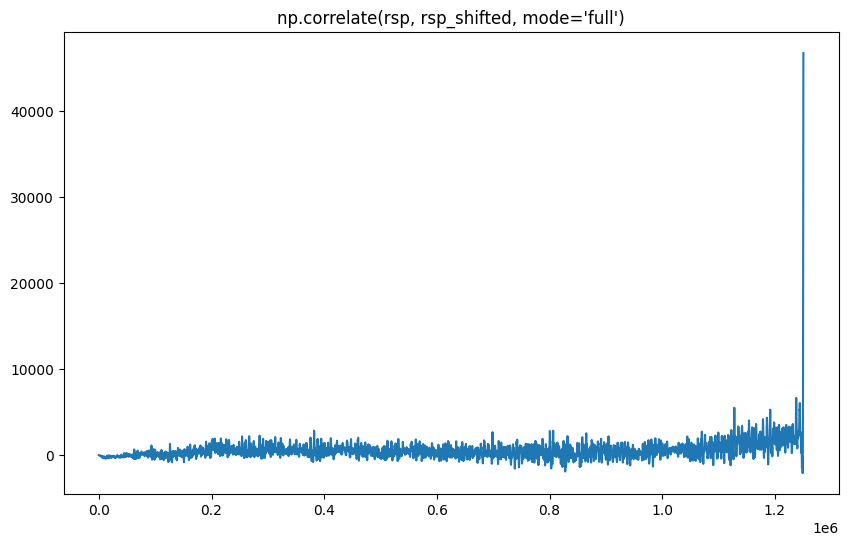

In [122]:
plt.plot(autocorr)
plt.title("np.correlate(rsp, rsp_shifted, mode='full')")

In [103]:
len(shift)

1251968

In [100]:
len(autocorr)

1253434

In [104]:
len(rsp)

1251968

In [102]:
shift = rsp.shift(lag)
shift

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
1251963    0.21973
1251964    0.21808
1251965    0.21753
1251966    0.21588
1251967    0.21533
Name: respiration, Length: 1251968, dtype: float32

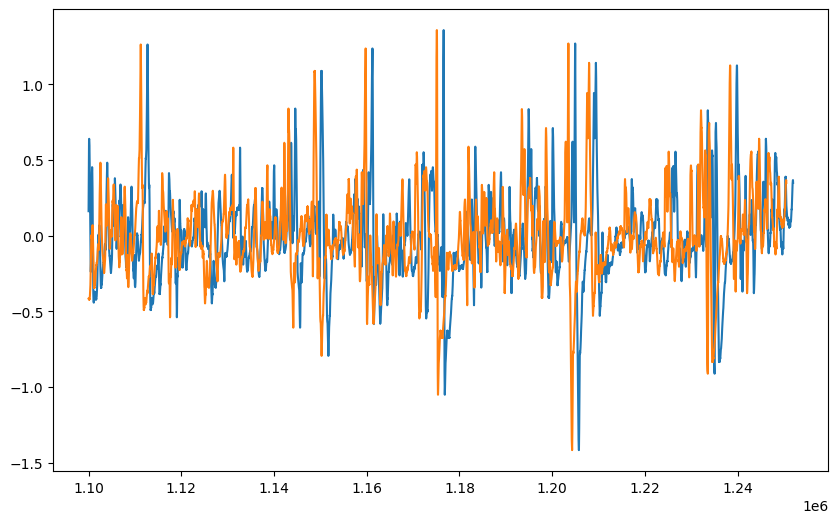

In [74]:
# plt.plot(rsp[1100000:])
plt.plot(rsp.index[1100000:], rsp[1100000:])
plt.plot(rsp.index[1100000:-lag], rsp[(1100000+lag):])

In [75]:
from pandas.core import nanops

self = pd.Series([0.25, 0.5, 0.2, -0.05])
other = pd.Series([0.5, 0.2, -0.05])

this, other = self.align(other, join = 'inner', copy = False)

# this, oth
nanops.nancorr(this.to_numpy(), other.to_numpy())

0.10355263309024072

In [76]:
self.autocorr(lag = 3)

/Users/camilla.strauss/anaconda3/envs/cuny_env/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/camilla.strauss/anaconda3/envs/cuny_env/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/camilla.strauss/anaconda3/envs/cuny_env/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


nan

In [77]:
self = pd.Series([0.25, 0.5, 0.2, -0.05, 0.25, 0.5, 0.2, -0.05])
other = pd.Series([-0.05, 0.25, 0.5, 0.2, -0.05])

this, other = self.align(other, join = 'inner', copy = False)

# this, oth
nanops.nancorr(this.to_numpy(), other.to_numpy())

-0.03046682320107413

In [78]:
lag

1467

In [79]:
rolling = rsp.rolling(window=200000).corr(rsp.shift(lag))
rolling

0               NaN
1               NaN
2               NaN
3               NaN
4               NaN
             ...   
1251963   -0.079237
1251964   -0.079232
1251965   -0.079227
1251966   -0.079222
1251967   -0.079217
Name: respiration, Length: 1251968, dtype: float64

In [80]:
np.corrcoef([rsp[:-lag], rsp[lag:]])[0, 1]


-0.06003212645183263

In [81]:
series.rolling(window=2)\
          .corr(series.shift())

NameError: name 'series' is not defined

In [ ]:
pd.rolling_apply(rsp, 50000, lambda x: pd.Series(x).autocorr(lag))


AttributeError: module 'pandas' has no attribute 'rolling_apply'

In [ ]:
# sliding window autocorrelation 

# for window of data, take autocorrelation, 

rolling = rsp.rolling(window=200000).apply(lambda x: x.autocorr(lag=int(median_breath_period * srate)))





KeyboardInterrupt: 

# Analyze RRV

In [ ]:
rrv = nk.rsp_rrv(rsp_rate, fixed_peaks, sampling_rate=srate)
rrv

,RRV_RMSSD,RRV_MeanBB,RRV_SDBB,RRV_SDSD,RRV_CVBB,RRV_CVSD,RRV_MedianBB,RRV_MadBB,RRV_MCVBB,RRV_VLF,...,RRV_MFDFA_alpha1_Increment,RRV_DFA_alpha2,RRV_MFDFA_alpha2_Width,RRV_MFDFA_alpha2_Peak,RRV_MFDFA_alpha2_Mean,RRV_MFDFA_alpha2_Max,RRV_MFDFA_alpha2_Delta,RRV_MFDFA_alpha2_Asymmetry,RRV_MFDFA_alpha2_Fluctuation,RRV_MFDFA_alpha2_Increment
0,1628.361919,2900.177536,1183.499392,1629.415711,0.408078,0.56147,2587.246661,693.654826,0.268105,NaN,...,0.168362,0.587831,0.54542,0.687886,0.737962,0.486826,-0.232017,-0.408187,0.000054,0.017363


In [ ]:
rrv # extract values from this for mean, sd
meanBB = rrv['RRV_MeanBB'][0] 
sdBB = rrv['RRV_SDBB'][0]

print(f"{meanBB:.8}, {sdBB:.8}")

print(f'Standard dev of Breath to Breath interval is {round(sdBB/meanBB * 100, 2)}% of Breath to Breath mean')

2900.1775, 1183.4994
Standard dev of Breath to Breath interval is 40.81% of Breath to Breath mean


# RSP_Plot

In [ ]:
rsp_signals, info = nk.rsp_process(rsp, sampling_rate = srate)


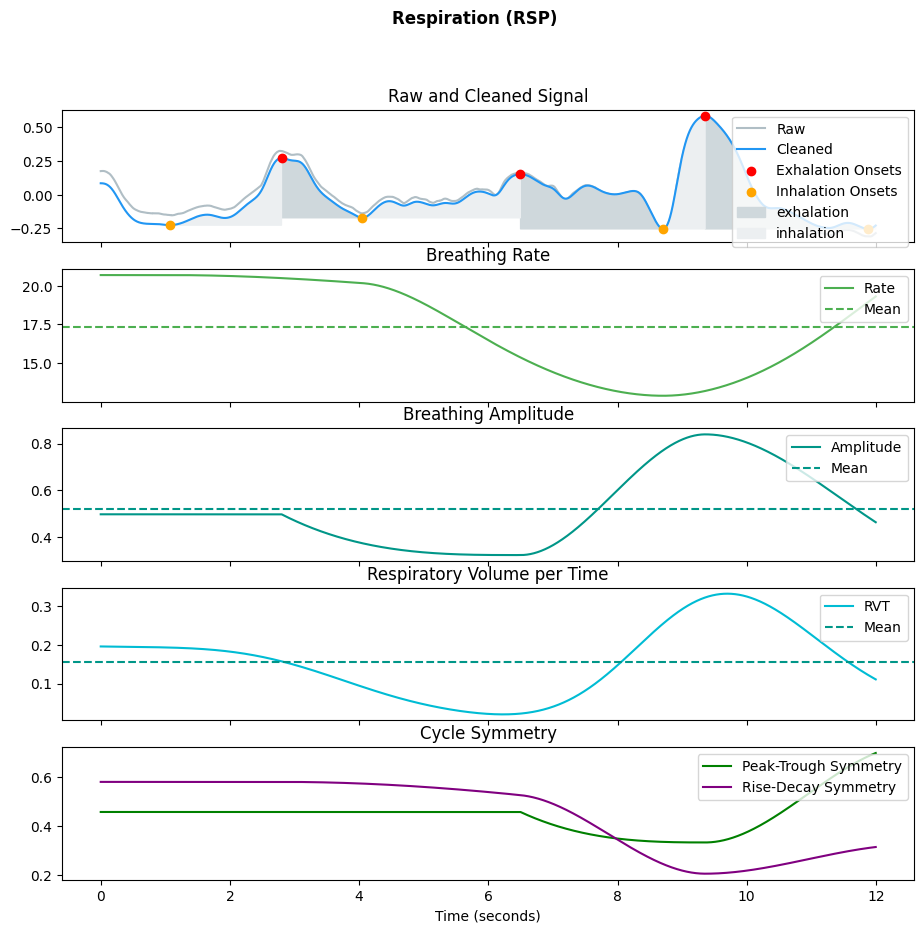

In [ ]:
nk.rsp_plot(rsp_signals[:6000], info)
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(11, 10) # Width, Height

plt.show()


# QC-- False Pos/Negs from Cleaning

In [ ]:
# Raw Peak Detection
raw_peaks_df, raw_peaks_dict = nk.rsp_peaks(rsp) # peaks_df: 1 where peaks and troughs are. dict: samples where peaks and troughs are
# raw_fixed_peaks = nk.rsp_fixpeaks(raw_peaks_dict)

In [ ]:
# Cleaned Peak Detection
cleaned_peaks_df, cleaned_peaks_dict = nk.rsp_peaks(cleaned) # peaks_df: 1 where peaks and troughs are. dict: samples where peaks and troughs are
# cleaned_fixed_peaks = nk.rsp_fixpeaks(cleaned_peaks_dict)

In [ ]:
false_positive = ((raw_peaks_df['RSP_Peaks'] == 1) & (cleaned_peaks_df['RSP_Peaks'] == 0)).sum()
false_negative = ((raw_peaks_df['RSP_Peaks'] == 0) & (cleaned_peaks_df['RSP_Peaks'] == 1)).sum() 
true_positive = ((raw_peaks_df['RSP_Peaks'] == 1) & (cleaned_peaks_df['RSP_Peaks'] == 1)).sum()
true_negative = ((raw_peaks_df['RSP_Peaks'] == 0) & (cleaned_peaks_df['RSP_Peaks'] == 0)).sum()

### FN, FP rate #1
#### out of all the things that should have been positive, how many were incorrectly marked negative?

In [ ]:
false_negative_rate1 = round(false_negative/((cleaned_peaks_df["RSP_Peaks"] == 1).sum()) * 100, 2) # same as round(false_negative/(false_negative+true_positive) * 100, 2)
false_negative_rate1 
# out of the however many peaks detected in cleaned, % were not detected in raw 

97.16

In [ ]:
false_positive_rate1 = round(false_positive/((cleaned_peaks_df["RSP_Peaks"] == 0).sum()) * 100, 2)
false_positive_rate1 

# out of the things that should have been negatibe , % were incorrectly labeled as peaks in raw


0.03

### FN, FP rate #2
### out of all the things that raw marked as negative, how many were wrong (should have been positive)?

In [ ]:
false_negative_rate2 = round(false_negative/((raw_peaks_df["RSP_Peaks"] == 0).sum()) * 100, 2)
false_negative_rate2

0.07

In [ ]:
false_positive_rate2 = round(false_positive/((raw_peaks_df["RSP_Peaks"] == 1).sum()) * 100, 2)
false_positive_rate2 

94.46

In [ ]:
print(f"false_positive: {false_positive} \n\
false_negative: {false_negative} \n\
true_positive: {true_positive} \n\
true_negative: {true_negative}")

false_positive: 375 
false_negative: 752 
true_positive: 22 
true_negative: 1122787


In [ ]:
(raw_peaks_df["RSP_Peaks"] == 0).sum()

1123539

In [ ]:
raw_peaks_df.sum()

RSP_Peaks      397
RSP_Troughs    397
dtype: int64

In [ ]:
cleaned_peaks_df.sum()

RSP_Peaks      774
RSP_Troughs    774
dtype: int64

# QC- SNR

In [ ]:
# raw signal
rsp_df = ps_df[['RESPIRATION0', 'lsl_time_stamp']].rename(columns={'RESPIRATION0': 'respiration'})
rsp = rsp_df.respiration

# cleaned signal
cleaned = nk.rsp_clean(rsp, sampling_rate=srate, method = 'khodadad')

# get power by np.var() on signal
signal_power = np.var(cleaned)

# Step 4: Estimate noise power (using residual noise after subtracting cleaned signal from noisy signal)
noise_signal = rsp - cleaned  # residual noise
noise_power = np.var(noise_signal)

snr = 10 * np.log10(signal_power / noise_power)
snr

13.999734215165274

In [ ]:
# raw signal
rsp_df = ps_df[['RESPIRATION0', 'lsl_time_stamp']].rename(columns={'RESPIRATION0': 'respiration'})
rsp = rsp_df.respiration

# cleaned signal
cleaned = nk.rsp_clean(rsp, sampling_rate=srate, method = 'hampel')

# get power by np.var() on signal
signal_power = np.var(cleaned)

# Step 4: Estimate noise power (using residual noise after subtracting cleaned signal from noisy signal)
noise_signal = rsp - cleaned  # residual noise
noise_power = np.var(noise_signal)

snr = 10 * np.log10(signal_power / noise_power)
snr

/Users/camilla.strauss/anaconda3/envs/cuny_env/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:204: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.10968  -0.0163   -0.0163   -0.0163   -0.0163   -0.0163   -0.12415
 -0.12415  -0.12415  -0.00861  -0.00861  -0.008515 -0.12964 ]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  rsp_signal[outlier_idx] = rolling_median[outlier_idx]


86.77660256160166

# Compare Cleaning Methods

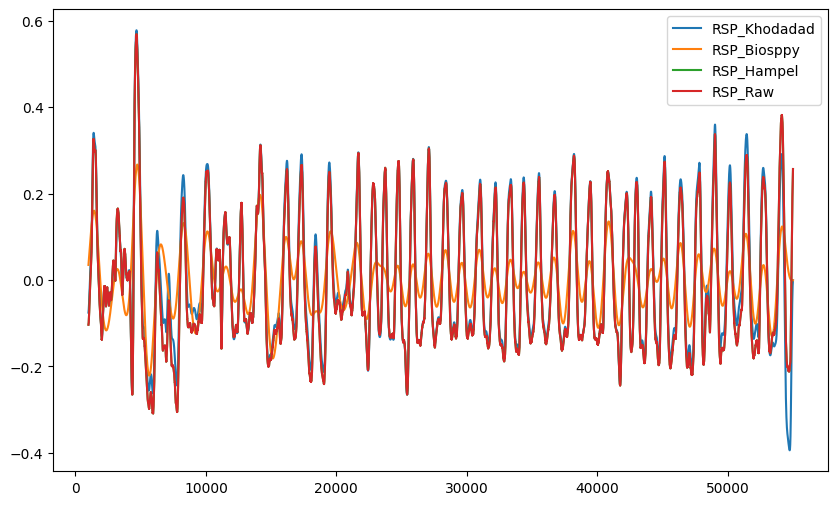

In [ ]:
rsp = rsp[1000:55000]

signals = pd.DataFrame({
    "RSP_Khodadad": nk.rsp_clean(rsp, sampling_rate=srate, method="khodadad2018"),
    "RSP_Biosppy": nk.rsp_clean(rsp, sampling_rate=srate, method="biosppy"),
    "RSP_Hampel": nk.rsp_clean(rsp, sampling_rate=srate, method="hampel", threshold=3), 
    "RSP_Raw": rsp
})


ax = signals.plot() # alpha = 0.6
# ax.get_lines()[signals.columns.get_loc("RSP_Raw")].set_alpha(0.5) # adjust alpha for one column

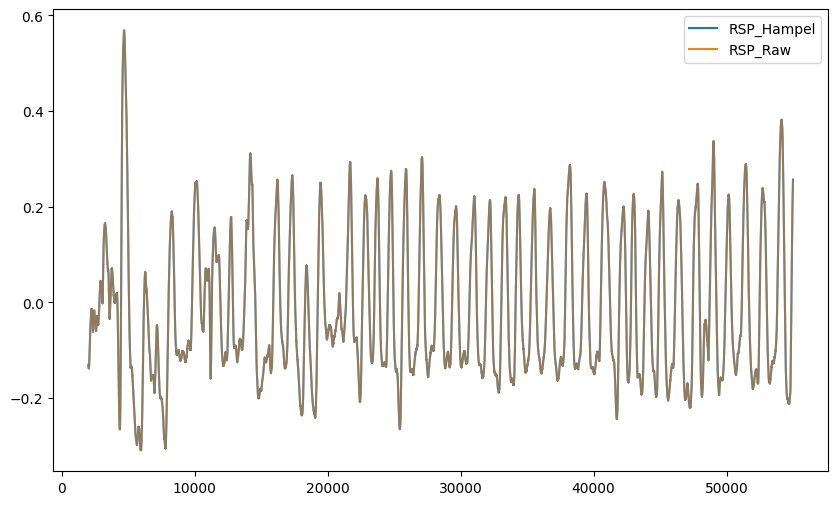

In [ ]:
rsp = rsp[1000:55000]

signals2 = pd.DataFrame({
    "RSP_Hampel": nk.rsp_clean(rsp, sampling_rate=srate, method="hampel", threshold=3), 
    "RSP_Raw": rsp
})


ax = signals2.plot()
ax.get_lines()[signals2.columns.get_loc("RSP_Raw")].set_alpha(0.5)

In [ ]:
# SNR khodadad 
# cleaned signal
cleaned_khodadad = signals['RSP_Khodadad']

# signal power
signal_power_khodadad = np.var(cleaned_khodadad)

# noise signal
noise_signal_khodadad = rsp - cleaned_khodadad

# noise power
noise_power_khodadad = np.var(noise_signal_khodadad)

# snr
snr_khodadad = 10 * np.log10(signal_power_khodadad / noise_power_khodadad)
snr_khodadad

14.475005491356015

In [ ]:
# SNR biosppy 
# cleaned signal
cleaned_biosppy = signals['RSP_Biosppy']

# signal power
signal_power_biosppy = np.var(cleaned_biosppy)

# noise signal
noise_signal_biosppy = rsp - cleaned_biosppy

# noise power
noise_power_biosppy = np.var(noise_signal_biosppy)

# snr
snr_biosppy = 10 * np.log10(signal_power_biosppy / noise_power_biosppy)
snr_biosppy


-4.1988264709804035

In [ ]:
# SNR hampel 
# cleaned signal
cleaned_hampel = signals['RSP_Hampel']

# signal power
signal_power_hampel = np.var(cleaned_hampel)

# noise signal
noise_signal_hampel = rsp - cleaned_hampel

# noise power
noise_power_hampel = np.var(noise_signal_hampel)

# snr
if noise_power_hampel == 0:
        snr_hampel = "no noise"
else:
    snr_hampel = 10 * np.log10(signal_power_hampel / noise_power_hampel)
snr_hampel


'no noise'

In [ ]:
compare_snr = {'khodadad': snr_khodadad,
'biosppy': snr_biosppy,
'hampel': snr_hampel}

subject = sub_files[sub_number].split('/')[4].split('-')[1]
print("sub", subject, "#", sub_number)
compare_snr

sub P5070899 # 8


{'khodadad': 14.475005491356015,
 'biosppy': -4.1988264709804035,
 'hampel': 'no noise'}

In [ ]:
# effective sampling rate
srate = PS['info']['effective_srate']
srate

500.145587073188